<a href="https://colab.research.google.com/github/mattiasthalen/Bayesian-Velocity-Profiling/blob/main/Bayesian_Velocity_Profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RepOne Strength

## Setup Environment


### Install Libraries

In [ ]:
!pip install numpyro
!pip install blackjax
!pip install pint_xarray
!pip install bottleneck
!pip install numbagg
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Setup Platform

In [ ]:
try:
    import jax.tools.colab_tpu
    import numpyro.util
    
    jax.tools.colab_tpu.setup_tpu()
    numpyro.util.set_platform('tpu')

    print('TPU assigned.')

    import jax
    display(jax.local_devices())

except:
    print('No TPU available, trying GPU.')
    
    try:
        numpyro.set_platform('gpu')
        
        print('GPU assigned.')

        import jax
        display(jax.local_devices())


    except:
        numpyro.set_platform('cpu')

        print('No GPU available, using CPU.')

        import jax
        display(jax.local_devices())
        


No TPU available, trying GPU.
GPU assigned.


[GpuDevice(id=0, process_index=0)]

### Load Libraries

In [ ]:
%load_ext autotime

time: 350 µs (started: 2022-09-07 07:03:36 +00:00)


In [ ]:
import pymc as pm
import pymc.sampling_jax

time: 5.61 s (started: 2022-09-07 07:03:36 +00:00)


/usr/local/lib/python3.7/dist-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [ ]:
import time
import pint_xarray
import warnings
import google

import requests
import numpyro
import sklearn.preprocessing
import sklearn.metrics

import pandas as pd
import numpy as np
import arviz as az
import xarray as xr

from jax import numpy as jnp
from numpyro import distributions as dist

from collections import OrderedDict
from google.colab import drive
from requests import get
from urllib.parse import unquote

from requests import get
from urllib.parse import unquote
from matplotlib import pyplot as plt

from typing import Callable, Optional, Dict, List, Union, NoReturn

time: 399 ms (started: 2022-09-07 07:03:41 +00:00)


### Set Global Vars

In [ ]:
rng_key = jax.random.PRNGKey(33)
n_devices = len(jax.local_devices())
numpyro.set_host_device_count(n_devices)

time: 1.58 s (started: 2022-09-07 07:03:42 +00:00)


In [ ]:
plt.style.use('bmh')

time: 1.62 ms (started: 2022-09-07 07:03:43 +00:00)


In [ ]:
csv_path = 'https://raw.githubusercontent.com/mattiasthalen/Bayesian-Velocity-Profiling/main/RepOne_Data_Export.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.33 s (started: 2022-09-07 07:03:43 +00:00)


## Functions

### Regression Functions

In [ ]:
def calc_obs_weight(mvt, velocity, weight, max_weight):
    try:
        mvt = mvt.pint.dequantify()
        velocity = velocity.pint.dequantify()
        weight = weight.pint.dequantify()
        max_weight = max_weight.pint.dequantify()
    except:
        pass
    finally:
        obs_weight = 0.5**((1 - mvt/velocity)/0.2) * 0.5**((1 - weight/max_weight)/0.2)
        
    return obs_weight

time: 1.87 ms (started: 2022-09-07 07:03:46 +00:00)


In [ ]:
def linear_fn(x, intercept, slope):
    return intercept + slope*x

def linear_rev_fn(x, intercept, slope):
    return (x - intercept)/slope

def linear_fit(ds, var, coord, reduce_dims):
    ds = ds.where((ds.coords['set_type'] != 'Back Off') & (ds['workup_sets'] > 2), drop = True)\
              .sel({'aggregation': 'max'}, drop = True)\
              .pint.dequantify()

    coefs = ds[var].curvefit(coords = ds[coord],
                             func = linear_fn,
                             reduce_dims = reduce_dims)\
                   .rename({'param': 'regression_param'})
    
    return coefs['curvefit_coefficients']

def linear_predict(x, coefs, reverse = False):
    intercept = coefs.sel(regression_param = 'intercept', drop = True)
    slope = coefs.sel(regression_param = 'slope', drop = True)

    if reverse:
            return linear_rev_fn(x, intercept, slope)

    return linear_fn(x, intercept, slope)

time: 12.3 ms (started: 2022-09-07 07:03:46 +00:00)


### Plotting Functions

In [ ]:
def plot_pbc(ds, exercise, data_var, window = 20, signal_window = 8, ax = None):
    df = ds[data_var].sel({'exercise': exercise}, drop = True)\
                     .drop_vars(['training_cycle', 'cycle_type', 'max_weight_pr_flag'])\
                     .to_dataframe()\
                     .dropna()
    
    df['moving_average'] = df[data_var].sort_index(ascending = False)\
                                       .rolling(window, min_periods = 1)\
                                       .mean()
    
    df['moving_range'] = df[data_var].diff(-1)\
                                     .abs()\
                                     .sort_index(ascending = False)\
                                     .rolling(window, min_periods = 1)\
                                     .mean()

    df['process_average'] = df['moving_average']
    df['process_range'] = df['moving_range']
    df['signal'] = None
    df['signal_min'] = None
    df['signal_max'] = None
    df['signal_above_average'] = None
    df['signal_below_average'] = None

    n_rows = len(df)
    previous_signal_id = 0

    for row in np.arange(n_rows):
        first_row = row == 0
        sufficient_rows_left = n_rows - row >= window

        signal_start_id = np.max([8, row - signal_window])

        df['signal_min'][row] = df[data_var][signal_start_id:row].min()
        df['signal_max'][row] = df[data_var][signal_start_id:row].max()

        df['signal_above_average'][row] = (df['signal_min'][row] > df['process_average'][row - 1])
        df['signal_below_average'][row] = (df['signal_max'][row] < df['process_average'][row - 1])

        signal_open = (first_row) | (row >= previous_signal_id + window)
        signal = (signal_open) & (sufficient_rows_left) & (first_row | df['signal_above_average'][row] | df['signal_below_average'][row])
        df['signal'][row] = signal
        
        df['process_average'][row] =  df['process_average'][row - 1]
        df['process_range'][row] =  df['process_range'][row - 1]

        if signal:
            previous_signal_id = row
            df['process_average'][row] =  df['moving_average'][row]
            df['process_range'][row] =  df['moving_range'][row]
        else:
            df['process_average'][row] =  df['process_average'][row - 1]
            df['process_range'][row] =  df['process_range'][row - 1]

    df['lower_limit_1'] = df['process_average'] - df['process_range']/1.128
    df['upper_limit_1'] = df['process_average'] + df['process_range']/1.128
    df['lower_limit_2'] = df['process_average'] - df['process_range']*2/1.128
    df['upper_limit_2'] = df['process_average'] + df['process_range']*2/1.128
    df['lower_limit_3'] = df['process_average'] - df['process_range']*3/1.128
    df['upper_limit_3'] = df['process_average'] + df['process_range']*3/1.128

    if ax is None:
        ax = plt.gca()

    ax.scatter(df.index, df[data_var], marker = '.', alpha = 0.6)
    ax.plot(df.index, df['process_average'])
    ax.plot(df.index, df['lower_limit_3'])
    ax.plot(df.index, df['upper_limit_3'])

    ax.fill_between(df.index,df['lower_limit_1'], df['upper_limit_1'], alpha = 0.3)

    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_ylim([0, None])
    ax.tick_params(labelrotation = 90)
    ax.grid()

    return ax

time: 21 ms (started: 2022-09-07 07:03:46 +00:00)


In [ ]:
def plot_kpis(ds, exercise, vars):
    var_titles = [var.title().replace('_', ' ').replace('1Rm', '1RM') for var in vars]

    n_vars = len(vars)

    n_cols = 1

    if n_vars > 1:
        n_cols = 2
    
    n_rows = 1

    if n_vars > 2:
        n_rows = np.ceil(n_vars/n_cols).astype(int)
    
    figsize = np.array([6, 3]) * [n_cols, n_rows]

    fig, axes = plt.subplots(ncols = n_cols,
                            nrows = n_rows,
                            constrained_layout = True,
                            figsize = figsize,
                            sharex = True)
    
    axes = [ax for row in axes for ax in row]

    for key, val in enumerate(vars):
        plot_pbc(ds, exercise, vars[key], ax = axes[key])
        title = var_titles[key]
        axes[key].set_title(title)

    fig.suptitle(f'{exercise.title()} KPIs', fontsize = 16)
    fig.supxlabel('Workout Start Time')

    plt.draw()

time: 3.62 ms (started: 2022-09-07 07:03:46 +00:00)


### ETL Functions

In [ ]:
def new_extract(csv_path, ds_path, **kwargs):
    try:
        return os.path.getmtime(csv_path) > os.path.getmtime(ds_path)
    except:
        return True

time: 1.01 ms (started: 2022-09-07 07:03:46 +00:00)


In [ ]:
def extract_data(csv_path, **kwargs):
    df = pd.read_csv(csv_path)

    df.columns = (df.columns
                    .str.lower()
                    .str.replace(' \(m/s\)', '')
                    .str.replace(' \(mm\)', '')
                    .str.replace(' \(sec\)', '')
                    .str.replace(' \(%\)', '')
                    .str.replace(' ', '_'))
    
    df.rename(columns = {'weight': 'load'}, inplace = True)

    df['workout_start_time'] = pd.to_datetime(df['workout_start_time'], format = '%d/%m/%Y, %H:%M:%S')

    df.dropna(subset = ['exercise'], inplace = True)
    df['rest_time'] = pd.to_timedelta(df['rest_time'])

    # Correct split session
    df['set'].mask((df['exercise'] == 'deadlift') & (df['workout_start_time'] == pd.to_datetime('2020-12-30 13:06:04')), df['set'] + 7, inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2020-12-30 13:06:04')}, pd.to_datetime('2020-12-30 12:53:09'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-01-07 11:50:22')}, pd.to_datetime('2021-01-07 11:20:07'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-06-10 12:02:22')}, pd.to_datetime('2021-06-10 11:56:31'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-06-14 12:06:00')}, pd.to_datetime('2021-06-14 11:57:50'), inplace = True)

    # Reindex sets & reps to counter bugs in the extract
    df['set'] = df.groupby(['exercise', 'workout_start_time'])['set'].apply(lambda x: (x != x.shift()).cumsum() - 1)
    df['rep'] = df.groupby(['exercise', 'workout_start_time', 'set']).cumcount()

    # Convert from , to . as decimal sign
    df['load'] = df['load'].str.replace(',', '.').astype('float')

    # Drop rows with tag fail
    fail_filter = df['tags'].str.contains('fail', na = False)
    df = df[~fail_filter]

    # Handle the case when a rep is split into two reps
    rep_split_filter = df['tags'].str.contains('rep split', na = False)

    rep_split_df = df[rep_split_filter].groupby(['exercise', 'workout_start_time', 'set', 'load', 'metric'])[['range_of_motion', 'duration_of_rep']].sum()
    rep_split_df['avg_velocity'] = rep_split_df['range_of_motion']/1000/rep_split_df['duration_of_rep']
    rep_split_df['rep'] = 0
    rep_split_df.reset_index(inplace = True)

    rep_split_df = rep_split_df.groupby(['exercise', 'workout_start_time', 'set', 'rep']).max()

    df = pd.concat([df[~rep_split_filter], rep_split_df])

    # Group to get multi index
    df = df.groupby(['exercise', 'workout_start_time', 'set', 'rep']).max()

    return df

time: 7.41 ms (started: 2022-09-07 07:03:46 +00:00)


In [ ]:
def define_cycles(cycles, min_workout_start_time, **kwargs):
    cycle_start_dates = np.array(list(cycles.keys())).astype('datetime64[ns]')

    if min_workout_start_time < cycle_start_dates.min():
        cycles = {min_workout_start_time.strftime('%Y-%m-%d'): 'n/a', **cycles}
        cycle_start_dates = np.array(list(cycles.keys())).astype('datetime64[ns]')

    cycle_types = np.array(list(cycles.values()))
    cycle_id = np.arange(len(cycle_start_dates))

    ds = xr.Dataset(coords = {'workout_start_time': cycle_start_dates,
                              'training_cycle': ('workout_start_time', cycle_id),
                              'cycle_type': ('workout_start_time', cycle_types)})

    return ds

time: 2.29 ms (started: 2022-09-07 07:03:46 +00:00)


In [ ]:
def transform_data(df, **kwargs):
    # Convert to xarray
    ds = df.to_xarray()

    # Change Set and Rep to integers
    ds['set'] = ds['set'].astype(int)
    ds['rep'] = ds['rep'].astype(int)

    # Move variables to coords
    ds = ds.set_coords(['metric', 'tags'])

    # Define UOMs
    ds = ds.pint.quantify({'load': 'kg',
                           'avg_velocity': 'meter / second',
                           'peak_velocity': 'meter / seconds',
                           'range_of_motion': 'mm',
                           'duration_of_rep': 's'})

    # Session meta data
    session_stack = ['exercise', 'workout_start_time']
    ds['session_max_load'] = ds['load'].stack(stack = session_stack)\
                                       .groupby('stack')\
                                       .reduce(all_nan_max, ...)\
                                       .unstack()

    # Set meta data
    set_stack = ['exercise', 'workout_start_time', 'set']
    ds['load'] = (ds['load'].stack(stack = set_stack)
                            .groupby('stack')
                            .reduce(all_nan_max, ...)
                            .unstack())

    ds['reps'] = (ds['avg_velocity'].stack(stack = set_stack)
                                    .groupby('stack')
                                    .count(...)
                                    .unstack()
                                    .where(ds['load'] > 0, drop = True))

    ds['set_velocities'] = summarize(ds['avg_velocity'].pint.dequantify())
    ds['set_velocities'] = ds['set_velocities'].pint.quantify({ds['set_velocities'].name: 'mps'})

    ds.coords['set_type'] = assign_set_type(ds['load'])

    # Merge training cycle coordinates
    cycles = define_cycles(**kwargs)
    ds = ds.merge(cycles, join = 'outer')
    ds['cycle_type'] = ('workout_start_time', ds['cycle_type'].to_series().ffill())
    ds['training_cycle'] = ds['training_cycle'].ffill('workout_start_time').astype(int)

    # Add the running min top set velocity per exercise
    ds['minimum_velocity_threshold'] = (ds['set_velocities'].sel({'aggregation': 'first'})
                                                            .where(ds.coords['set_type'] == 'Top Set')
                                                            .pint.dequantify()
                                                            .stack(stack = ['exercise', 'workout_start_time'])
                                                            .groupby('stack')
                                                            .reduce(all_nan_min, ...)
                                                            .unstack()
                                                            .rolling({'workout_start_time': len(ds['workout_start_time'])},
                                                                    min_periods = 1)
                                                            .min())
    ds['minimum_velocity_threshold'] = ds['minimum_velocity_threshold'].pint.quantify({ds['minimum_velocity_threshold'].name: 'meter / second'})

    # Add running max load per exercise
    ds['rolling_max_load'] = (ds['load'].pint.dequantify()
                                             .stack(stack = ['exercise', 'workout_start_time'])
                                             .groupby('stack')
                                             .reduce(all_nan_max, ...)
                                             .unstack()
                                             .rolling({'workout_start_time': len(ds['workout_start_time'])},
                                                      min_periods = 1)
                                             .max())
    ds['rolling_max_load'] = ds['rolling_max_load'].pint.quantify({ds['rolling_max_load'].name: 'kg'})

    # Generate the observation weights
    ds['observation_weight'] = calc_obs_weight(ds['minimum_velocity_threshold'], ds['set_velocities'], ds['load'], ds['session_max_load'])

    # Additional session meta data
    ds['workup_sets'] = ds['load'].where(ds.coords['set_type'] == 'Work Up', drop = True)\
                                  .stack(stack = session_stack)\
                                  .groupby('stack')\
                                  .count(...)\
                                  .unstack()
    
    ds['session_regression_coefficients'] = linear_fit(ds, 'load', 'set_velocities', 'set')

    ds['estimated_1rm'] = linear_predict(ds['minimum_velocity_threshold'].pint.dequantify(), ds['session_regression_coefficients'])
    ds['estimated_1rm'] = ds['estimated_1rm'].pint.quantify({ds['estimated_1rm'].name: 'kg'})

    ds['zero_velocity_load'] = linear_predict(0, ds['session_regression_coefficients'])
    ds['zero_velocity_load'] = ds['zero_velocity_load'].pint.quantify({ds['zero_velocity_load'].name: 'kg'})

    ds['zero_load_velocity'] = linear_predict(0, ds['session_regression_coefficients'], reverse = True)
    ds['zero_load_velocity'] = ds['zero_load_velocity'].pint.quantify({ds['zero_load_velocity'].name: 'mps'})

    ds['curve_score'] = ds['zero_velocity_load'].pint.dequantify()*ds['zero_load_velocity'].pint.dequantify()/2

    ds['session_volume'] = (ds['load'] * ds['reps']).stack(stack = session_stack).groupby('stack').sum(...).unstack()
    ds['session_relative_volume'] = ds['session_volume']/ds['estimated_1rm']

    # Rep meta data
    ds['rep_exertion'] = linear_predict(ds['avg_velocity'].pint.dequantify(), ds['session_regression_coefficients'])/ds['estimated_1rm'].pint.dequantify()
    ds['rep_force'] = (ds['load']*ds['range_of_motion'].pint.to('meter')/ds['duration_of_rep']**2).pint.to('N')
    ds['rep_energy'] = (ds['rep_force']*ds['range_of_motion'].pint.to('meter')).pint.to('J')

    # Session meta data
    ds['session_exertion_load'] = ds['rep_exertion'].stack(stack = ['exercise', 'workout_start_time']).groupby('stack').reduce(all_nan_sum, ...).unstack().pint.dequantify()

    # Add PR coordinates
    ds.coords['max_load_pr_flag'] = ds['rolling_max_load'].diff('workout_start_time') > 0

    return ds

time: 12.5 ms (started: 2022-09-07 07:03:46 +00:00)


In [ ]:
def etl_data(**kwargs):
    df = extract_data(**kwargs)

    min_workout_start_time = df.index.get_level_values('workout_start_time').min().floor('D')

    ds = transform_data(df, min_workout_start_time = min_workout_start_time, **kwargs)

    return ds
    
    try:
        os.remove(ds_path)
    except:
        pass

    try:
        ds.to_netcdf(ds_path)
    except PermissionError:
        print('PermissionError')    

    return ds   

time: 1.94 ms (started: 2022-09-07 07:03:46 +00:00)


In [ ]:
def get_data(**kwargs):
    #if not new_extract(**kwargs):
    #    return xr.open_dataset(kwargs['ds_path'])
    
    return etl_data(**kwargs)

time: 729 µs (started: 2022-09-07 07:03:46 +00:00)


### Miscellaneous Functions

In [ ]:
def assign_set_type(da):
    set_category = xr.where(da['set'] < da.idxmax('set'), 'Work Up', np.nan)
    set_category = xr.where(da['set'] == da.idxmax('set'), 'Top Set', set_category)
    set_category = xr.where(da['set'] > da.idxmax('set'), 'Back Off', set_category)
    set_category = xr.where(np.isnan(da), np.nan, set_category)
    
    return set_category

time: 1.77 ms (started: 2022-09-07 07:03:46 +00:00)


In [ ]:
def agg_summarize(x):
    x = x[np.isfinite(x)]

    if len(x) > 0:
        min = np.min(x)
        max = np.max(x)
        first = x[0]
        last = x[-1]
        peak_end = np.mean([min, last])
        mean = np.mean(x)
        median = np.median(x)
        hdi = az.hdi(x)
        result = np.array([min, max, first, last, peak_end, mean, median, *hdi])
    else:
        result = np.array([np.nan]*9)
    
    return result

def summarize(x, reduce_dim = 'rep'):
    summaries = xr.apply_ufunc(agg_summarize,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['aggregation']])
    
    summaries['aggregation'] = ['min', 'max', 'first', 'last', 'peak_end', 'mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

time: 3.7 ms (started: 2022-09-07 07:03:46 +00:00)


In [ ]:
def agg_hdi_summary(x):
    mean = x.mean()
    median = np.median(x)
    hdi = az.hdi(x)

    return np.array([mean, median, *hdi])

def hdi_summary(x, reduce_dim = 'sample'):
    try:
        x = x.pint.dequantify()
    except:
        pass

    summaries = xr.apply_ufunc(agg_hdi_summary,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['hdi_aggregation']])
    
    summaries['hdi_aggregation'] = ['mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

time: 14.5 ms (started: 2022-09-07 07:03:46 +00:00)


In [ ]:
def all_nan_summary(x, mode = 'mean', **kwargs):
    if np.all(np.isnan(x)):
        return np.nan
    elif mode == 'max':
        return np.nanmax(x)
    elif mode == 'min':
        return np.nanmin(x)
    elif mode == 'mean':
        return np.nanmean(x)
    elif mode == 'sum':
        return np.nansum(x)
        
def all_nan_max(x, **kwargs):
    return all_nan_summary(x, 'max', **kwargs)
        
def all_nan_min(x, **kwargs):
    return all_nan_summary(x, 'min', **kwargs)
        
def all_nan_mean(x, **kwargs):
    return all_nan_summary(x, 'mean', **kwargs)
        
def all_nan_sum(x, **kwargs):
    return all_nan_summary(x, 'sum', **kwargs)

time: 2.93 ms (started: 2022-09-07 07:03:46 +00:00)


In [ ]:
def profile(data, exercise, ds, mvt = None, plot = True, use_weights = True, **kwargs):
    tic = time.perf_counter()

    data = np.array(list(data.items()))
    
    load = data[:, 0]
    velocity = data[:, 1]
    
    # Set minimum velocity threshold
    if mvt is None:        
        try:
            mvt = ds['minimum_velocity_threshold'].sel({'exercise': exercise.lower()})[-1]
        except:
            mvt = mvt.mean()

        try:
            mvt = mvt.pint.dequantify().item()
        except:
            mvt = mvt.item()
    
    mvt = np.nanmin([mvt, velocity.min()])

    # Max load
    try:
        max_load = ds['rolling_max_weight'].sel({'exercise': exercise.lower()})[-1]
        try:
            max_load = max_load.pint.dequantify().item()
        except:
            max_load = max_load.item()
    except:
        max_load = np.nan
    
    max_load = np.nanmax([max_load, load.max()])
    
    if use_weights:
        weight = calc_obs_weight(mvt, velocity, load, max_load)
    else:
        weight = np.ones(len(load))

    #inference_data = quadratic_fit(load, velocity, weight, **kwargs)

    #if plot:
    #    plot_profile(inference_data, mvt, exercise, **kwargs)

    toc = time.perf_counter()
    print(f'Profile completed in {toc - tic:0.4f} seconds.')

    return data

time: 11.3 ms (started: 2022-09-07 07:03:46 +00:00)


## Load Data

In [ ]:
cycles = {'2021-01-05': '95% x1 + 75% x6+ @ 90%',
          '2021-01-27': '95% x1',
          '2021-02-01': '95% x1 + 75% x3+ @ 80%',
          '2021-02-15': '95% x1 + 80% x1 @ 85%',
          '2021-03-15': '95% x1 + 75% x6[3] @ 90%',
          '2021-03-24': '95% x1 + 75% x3 @ 90%',
          '2021-04-10': '95% x1 + 75% x2-3 @ 90-95% [320]',
          '2021-04-13': '95% x1 + 80% x2 @ 95% [320]',
          '2021-04-20': '95% x1',
          '2021-06-01': '95% x1 + 85% x2',
          '2021-07-06': 'YOLO',
          }

data = get_data(csv_path = csv_path,
              cycles = cycles)

data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


<xarray.Dataset>
Dimensions:                          (workout_start_time: 181, exercise: 5, set: 22, rep: 10, aggregation: 9, regression_param: 2)
Coordinates:
  * workout_start_time               (workout_start_time) datetime64[ns] 2020...
  * exercise                         (exercise) object 'bench press' ... 'squat'
  * set                              (set) int64 0 1 2 3 4 5 ... 17 18 19 20 21
  * rep                              (rep) int64 0 1 2 3 4 5 6 7 8 9
    metric                           (exercise, workout_start_time, set, rep) object ...
    tags                             (exercise, workout_start_time, set, rep) object ...
  * aggregation                      (aggregation) <U9 'min' ... 'hdi_upper'
    set_type                         (exercise, workout_start_time, set) object ...
    training_cycle                   (workout_start_time) float64 nan ... 11.0
    cycle_type                       (workout_start_time) object nan ... 'YOLO'
  * regression_param                 (regression_param) <U9 'intercept' 'slope'
    max_load_pr_flag                 (exercise, workout_start_time) float64 n...
Data variables: (12/26)
    load                             (exercise, workout_start_time, set) float64 [kg] ...
    set_rpe                          (exercise, workout_start_time, set, rep) object ...
    rest_time                        (exercise, workout_start_time, set, rep) timedelta64[ns] ...
    avg_velocity                     (exercise, workout_start_time, set, rep) float64 [m/s] ...
    range_of_motion                  (exercise, workout_start_time, set, rep) float64 [mm] ...
    peak_velocity                    (exercise, workout_start_time, set, rep) float64 [m/s] ...
    ...                               ...
    session_volume                   (exercise, workout_start_time) float64 [kg] ...
    session_relative_volume          (exercise, workout_start_time) float64 [] ...
    rep_exertion                     (exercise, workout_start_time, set, rep) float64 ...
    rep_force                        (exercise, workout_start_time, set, rep) float64 [N] ...
    rep_energy                       (exercise, workout_start_time, set, rep) float64 [J] ...
    session_exertion_load            (exercise, workout_start_time) float64 n...

time: 20.7 s (started: 2022-09-07 07:03:46 +00:00)


### Prepare Data For Inference

In [ ]:
regr_data = (data[['load', 'set_velocities', 'observation_weight']]
             .pint.dequantify()
             .sel({'aggregation': 'max'}, drop = True)
             .where(data.coords['set_type'] != 'Back Off')
             .where(data.coords['exercise'] != 'front squat')
             .drop_vars(['set_type', 'training_cycle', 'max_load_pr_flag'])
             .to_dataframe()
             .dropna()
             .reset_index()
             .sort_values(by = ['workout_start_time', 'exercise', 'set'])
             .rename(columns = {'set_velocities': 'velocity'}))

load_scaler = sklearn.preprocessing.StandardScaler()
regr_data['load_scaled'] = load_scaler.fit_transform(regr_data['load'].values.reshape(-1, 1))

velocity_scaler = sklearn.preprocessing.StandardScaler()
regr_data['velocity_scaled'] = velocity_scaler.fit_transform(regr_data['velocity'].values.reshape(-1, 1))

exercise_encoder = sklearn.preprocessing.LabelEncoder()
regr_data['exercise_id'] = exercise_encoder.fit_transform(regr_data['exercise'].values)

regr_data['session_id'] = regr_data.groupby(['exercise', 'workout_start_time'], sort = False).ngroup()

regr_data['observation'] = np.arange(len(regr_data))
regr_data.set_index('observation', inplace = True)

regr_data

,exercise,workout_start_time,set,load,velocity,observation_weight,cycle_type,load_scaled,velocity_scaled,exercise_id,session_id
observation,,,,,,,,,,,
0,deadlift,2020-12-30 12:53:09,0,70.0,0.63,0.010152,n/a,-0.076129,0.048990,1,0
1,deadlift,2020-12-30 12:53:09,1,80.0,0.50,0.015625,n/a,0.168831,-0.359654,1,0
2,deadlift,2020-12-30 12:53:09,2,90.0,0.49,0.019820,n/a,0.413791,-0.391088,1,0
3,deadlift,2020-12-30 12:53:09,3,100.0,0.64,0.019195,n/a,0.658750,0.080424,1,0
4,deadlift,2020-12-30 12:53:09,4,110.0,0.48,0.031250,n/a,0.903710,-0.422522,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2611,squat,2022-09-06 12:01:17,3,80.0,0.79,0.016052,YOLO,0.168831,0.551935,3,327
2612,squat,2022-09-06 12:01:17,4,100.0,0.64,0.031947,YOLO,0.658750,0.080424,3,327
2613,squat,2022-09-06 12:01:17,5,120.0,0.45,0.078745,YOLO,1.148670,-0.516824,3,327


time: 69.6 ms (started: 2022-09-07 07:04:07 +00:00)


In [ ]:
map_session_to_exercise_id = (regr_data[['session_id', 'exercise_id']]
                              .drop_duplicates()
                              .set_index('session_id', verify_integrity = True)
                              .sort_index()['exercise_id']
                              .values)

time: 7.43 ms (started: 2022-09-07 07:04:07 +00:00)


In [ ]:
data_dict = dict({
    'velocity_std': regr_data['velocity_scaled'].values,
    'load_std': regr_data['load_scaled'].values,
    'session_exercise_id': map_session_to_exercise_id,
    'session_id': regr_data['session_id'].values
})

time: 1.29 ms (started: 2022-09-07 07:04:07 +00:00)


## Inference

### Define Model

In [ ]:
def build_model(velocity_scaled,
                load_scaled,
                session_exercise_id,
                session_id,
                coords,
                render_model = True):
    
    with pm.Model(coords = coords) as model:
        # Inputs
        velocity_shared = pm.Data('velocity_scaled', velocity_scaled, mutable = True, dims = 'observation')
        session_exercise_id = pm.Data('session_exercise_id', session_exercise_id, mutable = True, dims = 'session')
        session_id = pm.Data('session_id', session_id, mutable = True,  dims = 'observation')

        # Global Parameters
        intercept_mu_global = pm.Normal(name = 'intercept_mu_global',
                                        mu = 0.0,
                                        sigma = 1.0)
        
        intercept_sigma_global = pm.HalfNormal(name = 'intercept_sigma_global',
                                            sigma = 1.0)
        
        slope_mu_global = pm.Gamma(name = 'slope_mu_global',
                                alpha = 2.0,
                                beta = 1.0)
        
        slope_sigma_global = pm.HalfNormal(name = 'slope_sigma_global',
                                        sigma = 1.0)
        
        curve_mu_global = pm.HalfNormal(name = 'curve_mu_global',
                                        sigma = 1.0)
        
        error_mu_global = pm.HalfNormal(name = 'error_mu_global',
                                        sigma = 1.0)
        
        # Exercise Parameters
        intercept_offset_exercise = pm.Normal(name = 'intercept_offset_exercise',
                                            mu = 0.0,
                                            sigma = 1.0,
                                            dims = 'exercise')
        
        intercept_mu_exercise = pm.Deterministic(name = 'intercept_mu_exercise',
                                                var = intercept_mu_global + intercept_sigma_global*intercept_offset_exercise,
                                                dims = 'exercise')
        
        intercept_sigma_exercise = pm.HalfNormal(name = 'intercept_sigma_exercise',
                                                sigma = 1.0,
                                                dims = 'exercise')
        
        slope_offset_exercise = pm.Gamma(name = 'slope_offset_exercise',
                                        alpha = 2.0,
                                        beta = 1.0,
                                        dims = 'exercise')
        
        slope_mu_exercise = pm.Deterministic(name = 'slope_mu_exercise',
                                            var = slope_mu_global + slope_sigma_global*slope_offset_exercise,
                                            dims = 'exercise')
        
        '''
        slope_mu_exercise = pm.Gamma(name = 'slope_mu_exercise',
                                    mu = slope_mu_global,
                                    sigma = slope_sigma_global,
                                    dims = 'exercise')
        '''

        slope_sigma_exercise = pm.HalfNormal(name = 'slope_sigma_exercise',
                                            sigma = 1.0,
                                            dims = 'exercise')
        
        curve_mu_exercise = pm.HalfNormal(name = 'curve_mu_exercise',
                                        sigma = 1.0/curve_mu_global,
                                        dims = 'exercise')
        
        '''
        error_mu_exercise = pm.HalfNormal(name = 'error_mu_exercise',
                                        sigma = 1.0/error_mu_global,
                                        dims = 'exercise')
        '''
        
        # Session Parameters
        intercept_offset_session = pm.Normal(name = 'intercept_offset_session',
                                            mu = 0.0,
                                            sigma = 1.0,
                                            dims = 'session')

        intercept_mu_session = pm.Deterministic(name = 'intercept_mu_session',
                                                var = (intercept_mu_exercise[session_exercise_id]
                                                    + intercept_sigma_exercise[session_exercise_id]
                                                    * intercept_offset_session[session_exercise_id]),
                                                dims = 'session')

        slope_offset_session = pm.Gamma(name = 'slope_offset_session',
                                        alpha = 2.0,
                                        beta = 1.0,
                                        dims = 'session')
        
        slope_mu_session = pm.Deterministic(name = 'slope_mu_session',
                                            var = (slope_mu_exercise[session_exercise_id]
                                                + slope_sigma_exercise[session_exercise_id]
                                                * slope_offset_session[session_exercise_id]),
                                            dims = 'session')
        
        '''
        slope_mu_session = pm.Gamma(name = 'slope_mu_session',
                                    mu = slope_mu_exercise[session_exercise_id],
                                    sigma = slope_sigma_exercise[session_exercise_id],
                                    dims = 'session')
        '''
        
        curve_mu_session = pm.HalfNormal(name = 'curve_mu_session',
                                        sigma = 1.0/curve_mu_exercise[session_exercise_id],
                                        dims = 'session')
        
        '''
        error_mu_session = pm.HalfNormal(name = 'error_mu_session',
                                        sigma = 1.0/error_mu_exercise[session_exercise_id],
                                        dims = 'session')
        '''

        # Final Parameters
        intercept = intercept_mu_session[session_id]
        slope = slope_mu_session[session_id]
        curve = curve_mu_session[session_id]
        error = error_mu_global#error_mu_session[session_id]

        # Estimated Value
        load_mu = pm.Deterministic(name = 'load_mu',
                                var = intercept - slope*velocity_shared - curve*velocity_shared**2,
                                dims = 'observation')

        # Likelihood
        load_likelihood = pm.Normal(name = 'load_scaled',
                                    mu = load_mu,
                                    sigma = error,
                                    observed = load_scaled,
                                    dims = 'observation')
    
    if render_model:
        display(pm.model_to_graphviz(model))

    return model

time: 5.08 ms (started: 2022-09-07 07:10:50 +00:00)


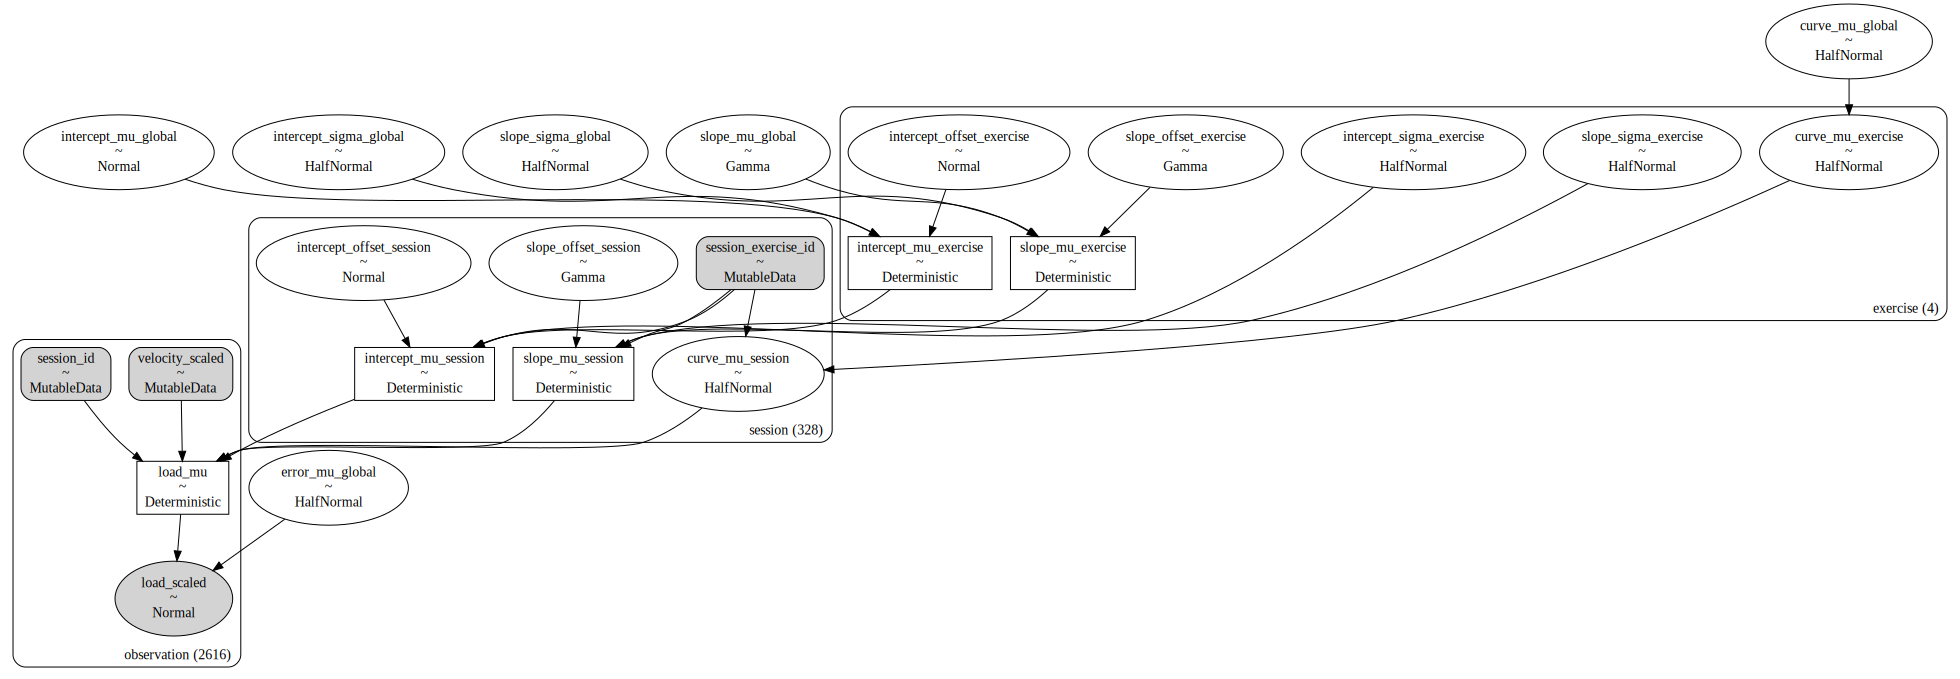

time: 301 ms (started: 2022-09-07 07:10:55 +00:00)


In [ ]:
velocity_scaled = regr_data['velocity_scaled']
load_scaled = regr_data['load_scaled']
session_exercise_id = map_session_to_exercise_id
session_id = regr_data['session_id']

coords = {'observation': regr_data.index.values,
          'exercise': exercise_encoder.classes_,
          'session': regr_data['session_id'].unique()}

quadratic_model = build_model(velocity_scaled, load_scaled, session_exercise_id, session_id, coords)

### Sampling

#### Posterior

In [ ]:
with pymc_model:
    pymc_inference_data = pm.sampling_jax.sample_numpyro_nuts(draws = 2000,
                                                              tune = 2000,
                                                              chains = 1,
                                                              target_accept = 0.98)

pymc_inference_data

Compiling...
Compilation time =  0:00:04.260168
Sampling...


warmup:   1%|          | 29/4000 [00:24<55:41,  1.19it/s, 1023 steps of size 7.89e-04. acc. prob=0.86]  


KeyboardInterrupt: ignored

time: 41.6 s (started: 2022-09-07 07:11:06 +00:00)


In [ ]:
pymc_inference_data.extend(pm.sample_posterior_predictive(pymc_inference_data, model = pymc_model))

In [ ]:
pymc_inference_data

In [ ]:
_ = az.plot_trace(pymc_inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 20],
                  var_names = ['intercept_mu_global', 'slope_mu_global', 'curve_mu_global', 'error_mu_global'])

In [ ]:
_ = az.plot_trace(pymc_inference_data,
                  compact = True,
                  combined = True,
                  legend = True,
                  figsize = [15, 20],
                  var_names = ['intercept_mu_exercise', 'slope_mu_exercise', 'curve_mu_exercise'])

In [ ]:
_ = az.plot_trace(pymc_inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 20],
                  var_names = ['intercept_mu_session', 'slope_mu_session', 'curve_mu_session'])

#### Prior

In [ ]:
pymc_prior_predictive = pm.sample_prior_predictive(model = pymc_model)
pymc_prior_predictive

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

time: 1.03 s (started: 2022-09-07 06:32:48 +00:00)


## Prediction

### Generate Predictions

In [ ]:
def create_prediction_df(unique_session_df,
                         predict_velocity_series):
    unique_session_df = unique_session_df.copy()
    unique_session_df['_temp'] = True

    predict_velocity_df = pd.DataFrame(predict_velocity_series, columns = ['velocity_scaled'])
    predict_velocity_df['_temp'] = True

    df = (unique_session_df
          .merge(predict_velocity_df, on = ['_temp'])
          .drop('_temp', axis = 1))

    return df

In [ ]:
sessions = regr_data[['exercise', 'workout_start_time', 'exercise_id', 'session_id']].drop_duplicates()

velocity_start = 0.0
velocity_stop = np.ceil(regr_data['velocity'].max())
velocity = np.arange(velocity_start, velocity_stop*100 + 1)/100
velocity_scaled = velocity_scaler.transform(velocity.reshape(-1, 1)).flatten()

predict_velocities = pd.Series(velocity_scaled)

prediction_template = create_prediction_df(sessions, predict_velocities)
prediction_template

In [ ]:
prediction_template = prediction_template.merge(regr_data[['session_id', 'velocity_scaled', 'load_scaled']],
                                                how = 'left',
                                                on = ['session_id', 'velocity_scaled'])

prediction_template

In [ ]:
session_key, rng_key = jax.random.split(rng_key)

session_ids = prediction_template['session_id'].values
velocities = prediction_template['velocity_scaled'].values

predictive = numpyro.infer.Predictive(quadratic_model,
                                      posterior_samples = posterior_samples,
                                      return_sites = ['load_std'])

samples_predictive = predictive(session_key,
                                velocity_std = velocities,
                                session_exercise_id = map_session_to_exercise_id,
                                session_id = session_ids)

predictions = samples_predictive['load_std']
median = jnp.median(predictions, axis = 0)
lower, upper = numpyro.diagnostics.hpdi(predictions, axis = 0)

In [ ]:
prediction_df = prediction_template.copy()

# Add predictions
prediction_df['load_scaled_median'] = median
prediction_df['load_scaled_lower'] = lower
prediction_df['load_scaled_upper'] = upper

# Inverse scale all values
prediction_df['velocity'] = velocity_scaler.inverse_transform(prediction_df['velocity_scaled'].values.reshape(-1, 1))
prediction_df['load'] = load_scaler.inverse_transform(prediction_df['load_scaled'].values.reshape(-1, 1))
prediction_df['load_median'] = load_scaler.inverse_transform(prediction_df['load_scaled_median'].values.reshape(-1, 1))
prediction_df['load_lower'] = load_scaler.inverse_transform(prediction_df['load_scaled_lower'].values.reshape(-1, 1))
prediction_df['load_upper'] = load_scaler.inverse_transform(prediction_df['load_scaled_upper'].values.reshape(-1, 1))

prediction_df

In [ ]:
def plot_session(df, session_id, ax):
    filter = (df['session_id'] == session_id) & (df['load_median'] >= 0)
    data = df[filter]

    auc = sklearn.metrics.auc(data['velocity'], data['load_median'])

    zero_velocity_load = data['load_median'].max()
    zero_velocity_load_lower = data['load_lower'].max()
    zero_velocity_load_upper = data['load_upper'].max()

    zero_load_velocity = data['velocity'].max()

    exercise = data['exercise'].values[0]
    workout_time = pd.to_datetime(data['workout_start_time'].values[0]).strftime('%Y-%m-%d')

    ax.plot('velocity',
            'load',
            marker = 'o',
            linestyle = '',
            label = 'Observed',
            zorder = 2,
            data = data)
    
    ax.plot('velocity',
            'load_median',
            label = 'Median',
            zorder = 1,
            data = data)

    ax.fill_between(x = 'velocity',
                    y1 = 'load_lower',
                    y2 = 'load_upper',
                    alpha = 0.5,
                    color = '#ffcd3c',
                    label = '90% HDI',
                    zorder = 0,
                    data = data)

    ax.set_title(f'{exercise.title()}\n{workout_time}',
                 fontsize = 'large',
                 fontweight = 'bold')
    
    ax.annotate(f'Zero Velocity Load: {zero_velocity_load:.0f} [{zero_velocity_load_lower:.0f}-{zero_velocity_load_upper:.0f}] kg\nZero Load Velocity: {zero_load_velocity:.2f} m/s\nArea Under Curve: {auc:.0f}',
                xy = [0.9855, 0.865],
                xycoords = 'axes fraction',
                horizontalalignment = 'right',
                verticalalignment = 'top',
                bbox = {'boxstyle': 'round',
                        'edgecolor': '#bcbcbc',
                        'facecolor': '#eeeeee'})
    
    ax.legend()
    
    ax.set_xlabel('Velocity')
    ax.set_ylabel('Load')

### Plot Last Sessions

In [ ]:
exercise_last_session_ids = regr_data.groupby(['exercise_id'])['session_id'].max().values
n_exercises = len(exercise_last_session_ids)

n_cols = 1 if n_exercises == 1 else 2
n_rows = 1 if n_exercises <= 2 else  np.ceil(n_exercises/2).astype(int)

fig, axes = plt.subplots(n_cols, n_rows, figsize = (15, 15))

axes = np.array([axes])
axes = axes.flatten()

for i in np.arange(n_exercises):
    plot_session(prediction_df, exercise_last_session_ids[i], axes[i])

fig.suptitle('LAST SESSION PER EXERCISE',
             fontweight = 'bold',
             fontsize = 'x-large')

fig.tight_layout()

plt.show()